In [2]:
library(vegan)
library(ggplot2)
library(tidyverse)
library(MicrobeR)

In [3]:
col <- c("#E69F00",
         "#0072B2",
         "#D6604D",
         "#7570B3")

# Adonis for HP relative abundance 

In [4]:
bc=read.csv('core-metrics-results-1000/bray_curtis_distance_matrix.qza-unzip/e0e828c1-3936-47dc-a3e9-d5a8e0b185ca/data/distance-matrix.tsv',sep='\t',row.names=1)
jaccard=read.csv('core-metrics-results-1000/jaccard_distance_matrix.qza-unzip/62a42de0-e364-4526-b4ce-42b21e27bdee/data/distance-matrix.tsv',sep='\t',row.names=1)
unweightUF=read.csv('core-metrics-results-1000/unweighted_unifrac_distance_matrix.qza-unzip/56407260-c338-4b75-b5bf-4f111576b59b/data/distance-matrix.tsv',sep='\t',row.names=1)
weightUF=read.csv('core-metrics-results-1000/weighted_unifrac_distance_matrix.qza-unzip/d6812b2c-b743-4f66-aeb4-75765710f004/data/distance-matrix.tsv',sep='\t',row.names=1)

In [5]:
distance_metric <- list(bc,jaccard,weightUF,unweightUF)
distance_str <- c('Bray Curtis','Jaccard','Weighted UniFrac','Unweighted UniFrac')

In [6]:
head(bc,2)

,ERR1995049,ERR1995038,ERR1995100,ERR1995099,ERR1995073,ERR1994996,ERR1995111,ERR1994997,ERR1995023,ERR1995109,⋯,SRR8031281,SRR8031243,SRR8031248,SRR8031257,SRR8031263,SRR8031285,SRR8031235,SRR8031264,SRR8031256,SRR8031271
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ERR1995049,0.000,0.768,0.906,0.929,0.915,0.720,0.923,0.479,0.477,0.864,⋯,0.999,1,0.998,0.999,0.997,1,1,0.999,0.997,0.996
ERR1995038,0.768,0.000,0.794,0.881,0.807,0.999,0.891,0.846,0.847,0.812,⋯,1.000,1,0.999,0.999,0.998,1,1,0.999,0.997,0.999


In [7]:
md <- read.csv('../metadata-add-hp-ab-final.tsv',row.names=1,sep='\t') 
head(md,2)

,Age,BMI,BioProject,CagA,Center_Name,Collection_Date,Condition,Country,Diagnosis,Gender,⋯,gastrin,host_height,host_weight,hp,hp_relative_abundance,paried.sample,primer,sampleloc,sampling_method,smoker
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
ERR1995049,NA,,PRJEB21104,,CGR,,gastric cancer,United Kingdom,gastric cancer,,⋯,M100,NA,NA,positive,78.20510,,27F _388R,,gastric mucosa biopsy,
ERR1995038,NA,,PRJEB21104,,CGR,,gastric cancer,United Kingdom,gastric cancer,,⋯,M100,NA,NA,positive,11.57239,,27F _388R,,gastric mucosa biopsy,


In [8]:
md <- subset(md,Sample_type=="gastric mucosa") 

In [9]:
keep=read.csv('../samples_kept_analysis_final.tsv',sep='\t',row.names = 1)
head(keep,2)

,Name
,<chr>
ERR1995049,ERR1995049
ERR1995038,ERR1995038


In [10]:
keep_sample=intersect(row.names(md),row.names(keep))

In [11]:
dim(keep)

[1] 2198    1

In [12]:
md=md[keep_sample,]
dim(md)

[1] 2102   50

In [13]:
table(md$Study)


                PRJEB21104                 PRJEB21497 
                        77                         32 
                PRJEB22107                 PRJEB26931 
                        26                        235 
         PRJNA310127_China         PRJNA310127_Mexico 
                       157                        134 
PRJNA375772_Inner_Mongolia          PRJNA375772_Xi_an 
                       143                        201 
               PRJNA428883                PRJNA481413 
                       745                        320 
               PRJNA495436 
                        32 

In [14]:
study=unique(md$Study)
study

[1] "PRJEB21104"                 "PRJEB21497"                
 [3] "PRJEB22107"                 "PRJEB26931"                
 [5] "PRJNA310127_China"          "PRJNA310127_Mexico"        
 [7] "PRJNA375772_Inner_Mongolia" "PRJNA375772_Xi_an"         
 [9] "PRJNA495436"                "PRJNA428883"               
[11] "PRJNA481413"

In [15]:
# one study adonis calculate function
adnonis_Res <- function(p,dis){
    #per_study<-list()
    s_md <- subset(md,Study==p)
    sample_ids <- intersect(row.names(s_md),row.names(dis))
    s_md <- md[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    
    adnonis_res <- adonis(distance ~ hp_relative_abundance, data = s_md)$aov.tab
    return(adnonis_res)
}

In [16]:
#calculate beta div for each study
set.seed(1)
PerStudy_hp_beta<-list()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    #message(dis_str)
    for(p in study){
        
        #message(p)
        PerStudy_hp_beta[[dis_str]][[p]]<-adnonis_Res(p,dis)
   }
}

In [17]:

# results of to a dataframe
data <- data.frame()

for (dis_str in distance_str){
   adnonis_res <- data.frame(row.names=study) 
   for (p in study){       
       adnonis_res[p,1] <- PerStudy_hp_beta[[dis_str]][[p]]['hp_relative_abundance','R2']
       adnonis_res[p,2] <- PerStudy_hp_beta[[dis_str]][[p]]['hp_relative_abundance','Pr(>F)'] 
   }   
   names(adnonis_res) <- c('R2','pvalue')
   adnonis_res['study']<-row.names(adnonis_res)
   adnonis_res['metric'] <- dis_str
   data <- rbind(data, adnonis_res)        
}

#combine

df <- data.frame()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    
    sample_ids = intersect(row.names(md),row.names(dis))
    s_md <- md[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    adnonis_res <- adonis(distance ~ hp_relative_abundance, strata=s_md$Study,data = s_md)$aov.tab
    R2 <- adnonis_res['hp_relative_abundance','R2']
    pvalue <- adnonis_res['hp_relative_abundance','Pr(>F)']
    l <- data.frame('R2'=R2,'pvalue'=pvalue,'study'='Combined','metric'=dis_str)
    df <- rbind(df, l)
    
}

hp <- rbind(data,df) %>% mutate(Pvalue=case_when(
pvalue < 0.05 ~'P < 0.05',  
TRUE~"ns"
))


In [18]:
unique(hp$study)

[1] "PRJEB21104"                 "PRJEB21497"                
 [3] "PRJEB22107"                 "PRJEB26931"                
 [5] "PRJNA310127_China"          "PRJNA310127_Mexico"        
 [7] "PRJNA375772_Inner_Mongolia" "PRJNA375772_Xi_an"         
 [9] "PRJNA495436"                "PRJNA428883"               
[11] "PRJNA481413"                "Combined"

In [19]:
hp$study= factor(hp$study,levels=c('Combined','PRJNA495436','PRJNA481413','PRJNA428883',
                                  'PRJNA375772_Xi_an','PRJNA375772_Inner_Mongolia',
                                  'PRJNA310127_Mexico','PRJNA310127_China','PRJEB26931',
                                  'PRJEB22107','PRJEB21497','PRJEB21104'))

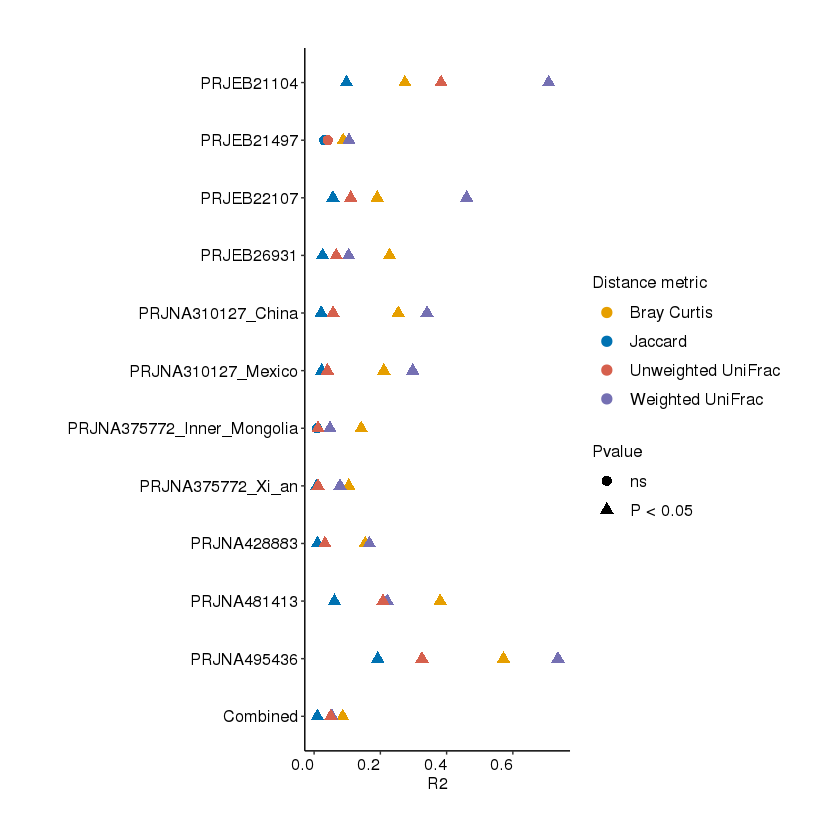

In [20]:
ggplot(data = hp, aes(x = R2, y =study,color=metric))+ geom_point(aes(shape =Pvalue),size=2.5)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ 
theme(axis.text.x = element_text(angle = 0, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
        legend.title = element_text(size = 10),
      legend.text = element_text(size = 10),
     plot.margin=unit(rep(2,4),'lines')
     )+scale_color_manual(values=col)+ylab('')+ labs(colour='Distance metric')


ggsave("figures/hprel_adonis.pdf", device="pdf", height=5, width=6, useDingbats=F)

# diagnosis 

In [21]:
# function gain each study each distance adonis results

beta_stat <- function(p,dis,c1,c2){
    As <- list()
    s_md <- subset(md,Study==p) %>% subset(Diagnosis==c1| Diagnosis==c2)
    sample_ids=intersect(row.names(s_md),row.names(dis))
    s_md <- s_md[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    
    adnonis_res <- adonis(distance ~ Diagnosis, data = s_md)$aov.tab
    return(adnonis_res)
}

## healthy vs gastritis 

In [22]:
md <- subset(md,Condition!='atrophic gastritis') %>%subset(Condition!='H.pylori atrophic gastritis')

In [23]:
dim(md)

[1] 1972   50

In [24]:
Project=c('PRJEB21104','PRJEB22107','PRJEB26931')

In [25]:
set.seed(1)
PerStudy_beta<-list()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    #message(dis_str)
    for(p in Project){        
        #message(p)
        PerStudy_beta[[dis_str]][[p]]<-beta_stat(p,dis,'healthy','gastritis')
   }
}

In [26]:
data <- data.frame()

for (dis_str in distance_str){
   diag_res <- data.frame(row.names=Project) 
   for (p in Project){       
       diag_res[p,1] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','R2']
       diag_res[p,2] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','Pr(>F)'] 
   }   
   names(diag_res) <- c('R2','pvalue')
   diag_res['study']<-row.names(diag_res)
   diag_res['metric'] <- dis_str
   data <- rbind(data, diag_res)      #   
}

# combined 
mtd <- subset(md,Study == 'PRJEB21104' | Study == 'PRJEB22107' | Study == 'PRJEB26931') %>% 
subset(Diagnosis == 'healthy'| Diagnosis == 'gastritis')

df <- data.frame()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    
    sample_ids = intersect(row.names(mtd),row.names(dis))
    s_md <- mtd[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    adnonis_res <- adonis(distance ~ Diagnosis, strata=s_md$Study,data = s_md)$aov.tab
    R2 <- adnonis_res['Diagnosis','R2']
    pvalue <- adnonis_res['Diagnosis','Pr(>F)']
    l <- data.frame('R2'=R2,'pvalue'=pvalue,'study'='Combined','metric'=dis_str)
    df <- rbind(df, l)
    
}

hg <- rbind(data,df) %>% mutate(Compare='Healthy vs. Gastritis') %>% mutate(Pvalue=case_when(
pvalue < 0.05 ~'P < 0.05',  
TRUE~"ns"
))

In [27]:
hg

,R2,pvalue,study,metric,Compare,Pvalue
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
PRJEB21104,0.27329481,0.001,PRJEB21104,Bray Curtis,Healthy vs. Gastritis,P < 0.05
PRJEB22107,0.09087176,0.049,PRJEB22107,Bray Curtis,Healthy vs. Gastritis,P < 0.05
PRJEB26931,0.25617726,0.001,PRJEB26931,Bray Curtis,Healthy vs. Gastritis,P < 0.05
PRJEB211041,0.11330168,0.001,PRJEB21104,Jaccard,Healthy vs. Gastritis,P < 0.05
PRJEB221071,0.04613104,0.249,PRJEB22107,Jaccard,Healthy vs. Gastritis,ns
PRJEB269311,0.14589424,0.001,PRJEB26931,Jaccard,Healthy vs. Gastritis,P < 0.05
PRJEB211042,0.71211405,0.001,PRJEB21104,Weighted UniFrac,Healthy vs. Gastritis,P < 0.05
PRJEB221072,0.04339932,0.356,PRJEB22107,Weighted UniFrac,Healthy vs. Gastritis,ns
PRJEB269312,0.03633489,0.050,PRJEB26931,Weighted UniFrac,Healthy vs. Gastritis,ns


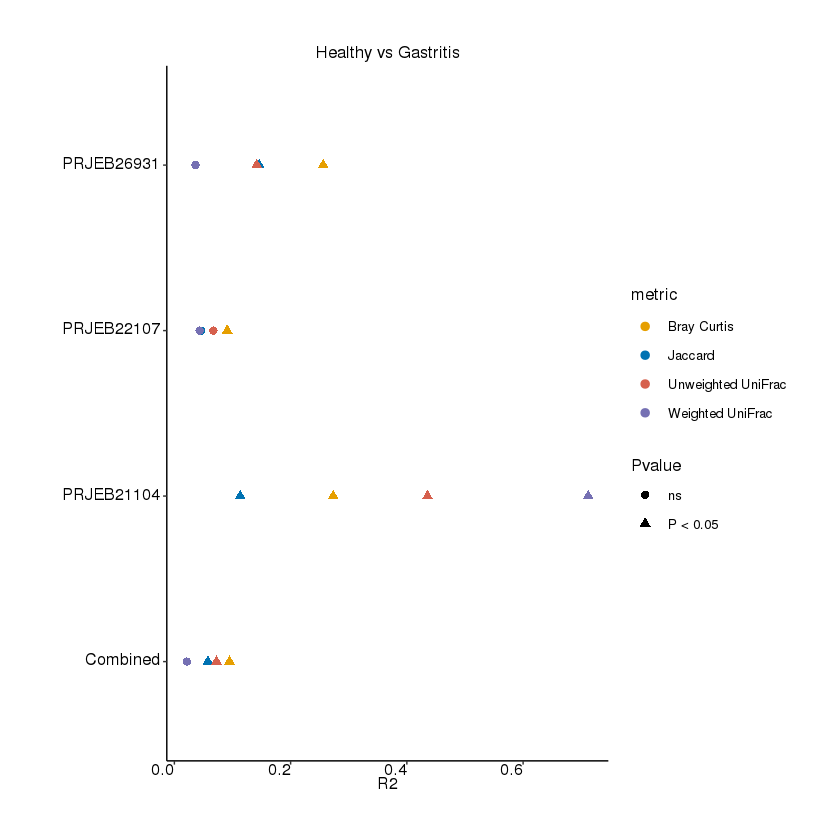

In [28]:
ggplot(data = hg, aes(x = R2, y =study,color=metric))+ geom_point(aes(shape =Pvalue),size=2)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ 
theme(axis.text.x = element_text(angle = 0, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
      legend.title = element_text(size = 10),
      legend.text = element_text(size = 8),
     plot.margin=unit(rep(2,4),'lines'))+scale_color_manual(values=col)+
labs(title = 'Healthy vs Gastritis',y='') #
ggsave("figures/healthy_vs_gastritis_adonis.pdf", device="pdf", height=3, width=5.2, useDingbats=F)

## healthy vs GC

In [29]:
Project=c('PRJEB21104','PRJEB21497','PRJEB26931')

In [30]:
set.seed(1)
PerStudy_beta<-list()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    #message(dis_str)
    for(p in Project){
        
        #message(p)
        PerStudy_beta[[dis_str]][[p]]<-beta_stat(p,dis,'healthy','gastric cancer')
   }
}

In [31]:
data <- data.frame()

for (dis_str in distance_str){
   diag_res <- data.frame(row.names=Project) 
   for (p in Project){       
       diag_res[p,1] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','R2']
       diag_res[p,2] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','Pr(>F)'] 
   }   
   names(diag_res) <- c('R2','pvalue')
   diag_res['study']<-row.names(diag_res)
   diag_res['metric'] <- dis_str
   data <- rbind(data, diag_res)      #   
}

# combined 
mtd <- subset(md,Study == 'PRJEB21104' | Study == 'PRJEB21497' | Study == 'PRJEB26931') %>% 
subset(Diagnosis == 'healthy'| Diagnosis == 'gastric cancer')

df <- data.frame()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    
    sample_ids = intersect(row.names(mtd),row.names(dis))
    s_md <- mtd[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    adnonis_res <- adonis(distance ~ Diagnosis, strata=s_md$Study,data = s_md)$aov.tab
    R2 <- adnonis_res['Diagnosis','R2']
    pvalue <- adnonis_res['Diagnosis','Pr(>F)']
    l <- data.frame('R2'=R2,'pvalue'=pvalue,'study'='Combined','metric'=dis_str)
    df <- rbind(df, l)
    
}

hgc <- rbind(data,df) %>% mutate(Compare='Healthy vs. GC') %>% #
mutate(Pvalue=case_when(pvalue < 0.05 ~'P < 0.05', TRUE~"ns"))

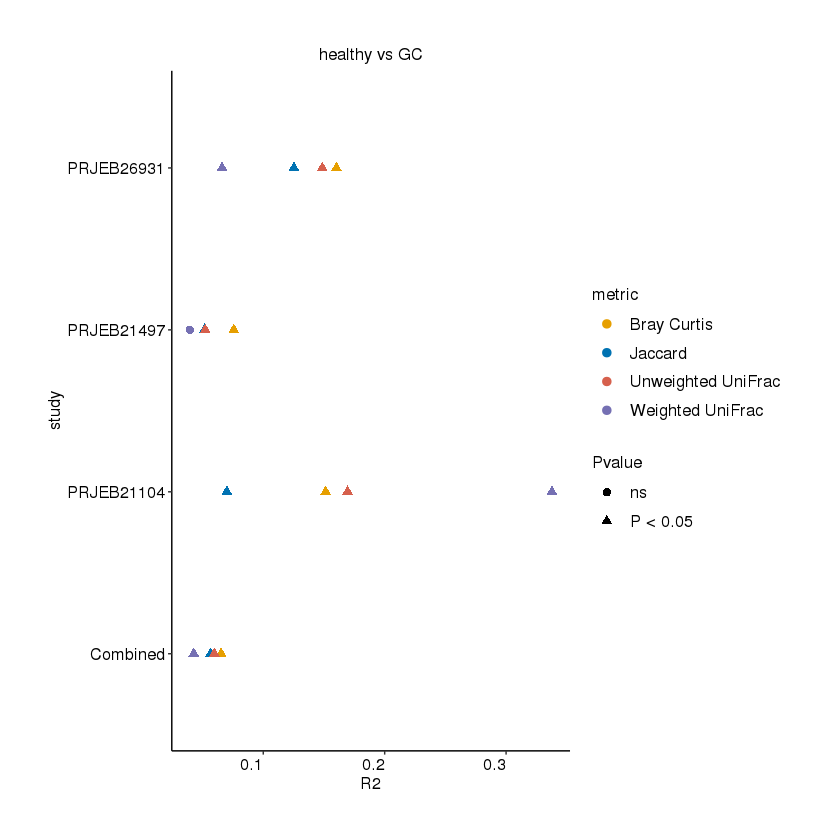

In [32]:
ggplot(data = hgc, aes(x = R2, y =study,color=metric))+ geom_point(aes(shape =Pvalue),size=2)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ 
theme(axis.text.x = element_text(angle = 0, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
        legend.title = element_text(size = 10),
      legend.text = element_text(size = 10),
     plot.margin=unit(rep(2,4),'lines')
     )+labs(title = 'healthy vs GC') +scale_color_manual(values=col)#
ggsave("figures/healthy_vs_GC_adonis.pdf", device="pdf", height=3, width=6, useDingbats=F)

## gastritis vs IM 

In [33]:
dim(md)

[1] 1972   50

In [34]:
Project=c('PRJEB21104','PRJEB26931','PRJNA375772_Xi_an','PRJNA481413')

In [35]:
table(md$Diagnosis)


       gastric cancer             gastritis               healthy 
                 1332                   340                   104 
intestinal metaplasia 
                  196 

In [36]:
set.seed(1)
PerStudy_beta<-list()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    #message(dis_str)
    for(p in Project){
        
        #message(p)
        PerStudy_beta[[dis_str]][[p]]<-beta_stat(p,dis,'gastritis','intestinal metaplasia')
   }
}

In [37]:
data <- data.frame()

for (dis_str in distance_str){
   diag_res <- data.frame(row.names=Project) 
   for (p in Project){       
       diag_res[p,1] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','R2']
       diag_res[p,2] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','Pr(>F)'] 
   }   
   names(diag_res) <- c('R2','pvalue')
   diag_res['study']<-row.names(diag_res)
   diag_res['metric'] <- dis_str
   data <- rbind(data, diag_res)         
}

# combined 
mtd <- subset(md,Study == 'PRJEB21104' | Study == 'PRJEB26931' | Study == 'PRJNA375772_Xi_an' | Study == 'PRJNA481413') %>%
subset(Diagnosis == 'gastritis'| Diagnosis == 'intestinal metaplasia')  #

df <- data.frame()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    
    sample_ids = intersect(row.names(mtd),row.names(dis))
    s_md <- mtd[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    adnonis_res <- adonis(distance ~ Diagnosis, strata=s_md$Study,data = s_md)$aov.tab
    R2 <- adnonis_res['Diagnosis','R2']
    pvalue <- adnonis_res['Diagnosis','Pr(>F)']
    l <- data.frame('R2'=R2,'pvalue'=pvalue,'study'='Combined','metric'=dis_str)
    df <- rbind(df, l)
    
}

gIM <- rbind(data,df) %>% mutate(Compare='Gastritis vs. IM') %>%                                        #
mutate(Pvalue=case_when(pvalue < 0.05 ~'P < 0.05', TRUE~"ns"))

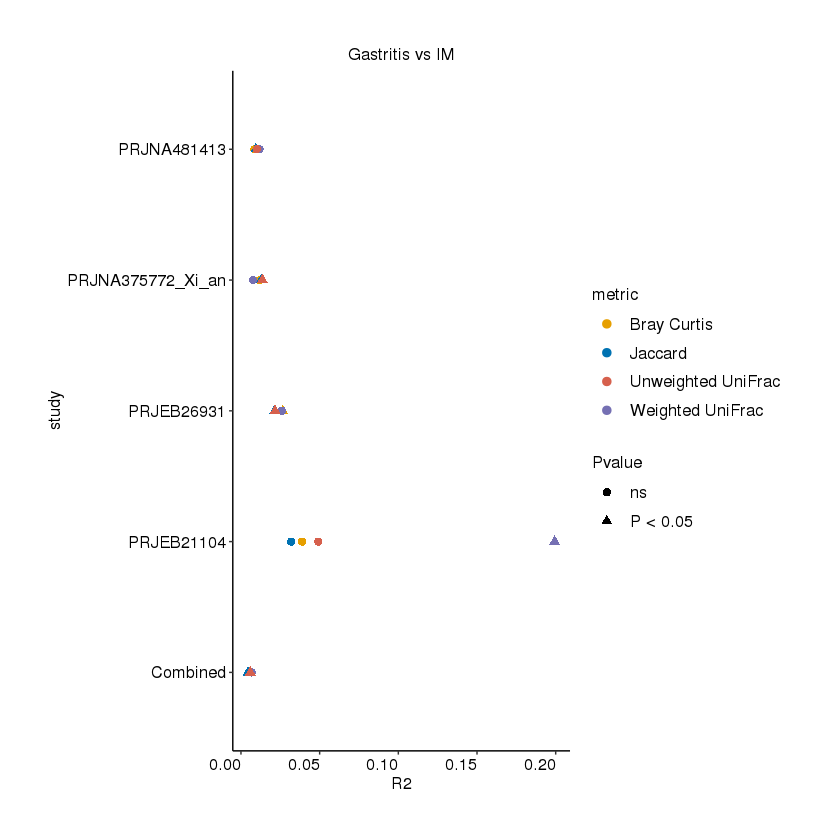

In [38]:
ggplot(data =gIM , aes(x = R2, y =study,color=metric))+ geom_point(aes(shape =Pvalue),size=2)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ 
theme(axis.text.x = element_text(angle = 0, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
        legend.title = element_text(size = 10),
      legend.text = element_text(size = 10),
     plot.margin=unit(rep(2,4),'lines')
     )+labs(title = 'Gastritis vs IM') +scale_color_manual(values=col)#
ggsave("figures/gastritis_vs_IM_adonis.pdf", device="pdf", height=3, width=6, useDingbats=F)

## gastritis vs GC 

In [39]:
Project<-c('PRJEB21104','PRJEB26931','PRJNA375772_Inner_Mongolia','PRJNA375772_Xi_an',
'PRJNA481413')

In [40]:
set.seed(1)
PerStudy_beta<-list()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    #message(dis_str)
    for(p in Project){
        
        #message(p)
        PerStudy_beta[[dis_str]][[p]]<-beta_stat(p,dis,'gastritis','gastric cancer')  #
   }
}

In [41]:
data <- data.frame()

for (dis_str in distance_str){
   diag_res <- data.frame(row.names=Project) 
   for (p in Project){       
       diag_res[p,1] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','R2']
       diag_res[p,2] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','Pr(>F)'] 
   }   
   names(diag_res) <- c('R2','pvalue')
   diag_res['study']<-row.names(diag_res)
   diag_res['metric'] <- dis_str
   data <- rbind(data, diag_res)         
}

# combined 
mtd <- subset(md,Study == 'PRJEB21104' | Study == 'PRJEB26931' | Study == 'PRJNA375772_Inner_Mongolia'| Study == 'PRJNA375772_Xi_an' | Study == 'PRJNA481413') %>%
subset(Diagnosis == 'gastritis'| Diagnosis == 'gastric cancer')  #

df <- data.frame()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    
    sample_ids = intersect(row.names(mtd),row.names(dis))
    s_md <- mtd[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    adnonis_res <- adonis(distance ~ Diagnosis,strata=s_md$Study, data = s_md)$aov.tab
    R2 <- adnonis_res['Diagnosis','R2']
    pvalue <- adnonis_res['Diagnosis','Pr(>F)']
    l <- data.frame('R2'=R2,'pvalue'=pvalue,'study'='Combined','metric'=dis_str)
    df <- rbind(df, l)
    
}

ggc <- rbind(data,df) %>% mutate(Compare='Gastritis vs. GC') %>%                                        #
mutate(Pvalue=case_when(pvalue < 0.05 ~'P < 0.05', TRUE~"ns"))

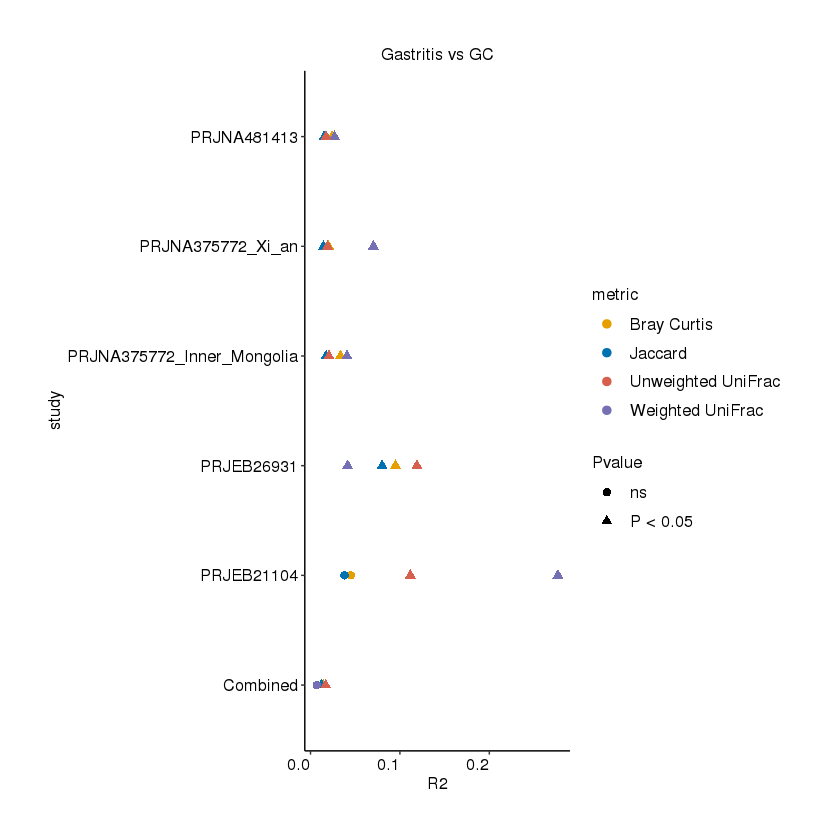

In [42]:
ggplot(data =ggc , aes(x = R2, y =study,color=metric))+ geom_point(aes(shape =Pvalue),size=2)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ #上右方框去掉了
theme(axis.text.x = element_text(angle = 0, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
        legend.title = element_text(size = 10),
      legend.text = element_text(size = 10),
     plot.margin=unit(rep(2,4),'lines')
     )+labs(title = 'Gastritis vs GC') +scale_color_manual(values=col)
ggsave("figures/gastritis_vs_GC_adonis.pdf", device="pdf", height=3.5, width=6.8, useDingbats=F)

## IM vs GC 

In [43]:
Project<-c('PRJEB21104','PRJEB26931','PRJNA375772_Xi_an',
'PRJNA481413')

In [44]:
set.seed(1)
PerStudy_beta<-list()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    #message(dis_str)
    for(p in Project){
        
        #message(p)
        PerStudy_beta[[dis_str]][[p]]<-beta_stat(p,dis,'intestinal metaplasia','gastric cancer')
   }
}

In [45]:
data <- data.frame()

for (dis_str in distance_str){
   diag_res <- data.frame(row.names=Project) 
   for (p in Project){       
       diag_res[p,1] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','R2']
       diag_res[p,2] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','Pr(>F)'] 
   }   
   names(diag_res) <- c('R2','pvalue')
   diag_res['study']<-row.names(diag_res)
   diag_res['metric'] <- dis_str
   data <- rbind(data, diag_res)         
}

# combined 
mtd <- subset(md,Study == 'PRJEB21104' | Study == 'PRJEB26931' | Study == 'PRJNA375772_Xi_an' | Study == 'PRJNA481413') %>%
subset(Diagnosis == 'intestinal metaplasia'| Diagnosis == 'gastric cancer')  #

df <- data.frame()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    
    sample_ids = intersect(row.names(mtd),row.names(dis))
    s_md <- mtd[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    adnonis_res <- adonis(distance ~ Diagnosis,strata=s_md$Study, data = s_md)$aov.tab
    R2 <- adnonis_res['Diagnosis','R2']
    pvalue <- adnonis_res['Diagnosis','Pr(>F)']
    l <- data.frame('R2'=R2,'pvalue'=pvalue,'study'='Combined','metric'=dis_str)
    df <- rbind(df, l)
    
}

IMGC <- rbind(data,df) %>% mutate(Compare='IM vs. GC') %>%                                        #
mutate(Pvalue=case_when(pvalue < 0.05 ~'P < 0.05', TRUE~"ns"))

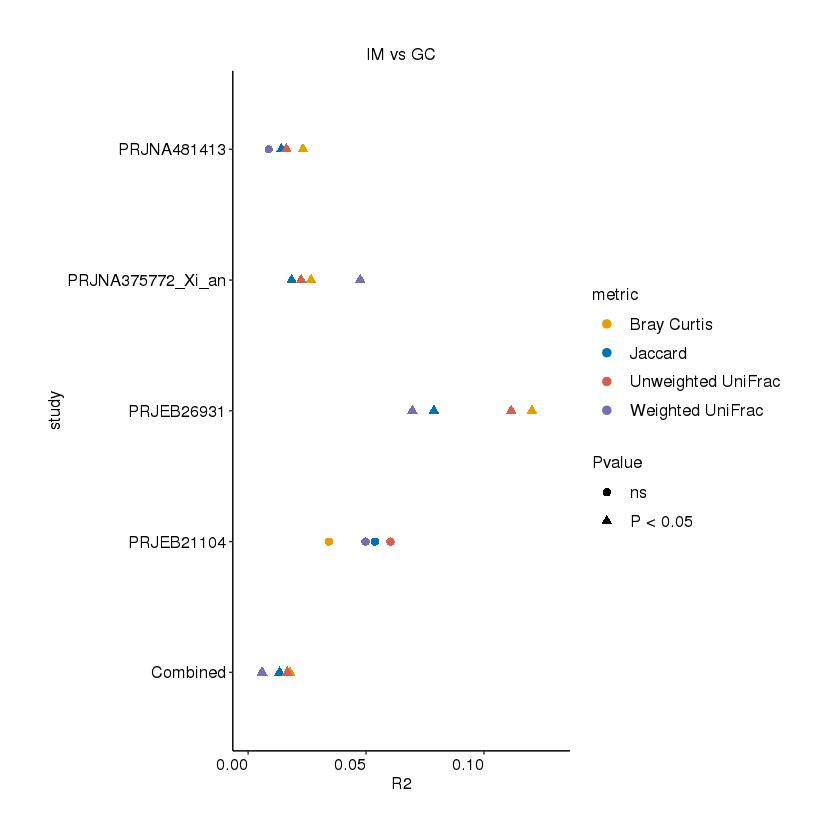

In [46]:
ggplot(data =IMGC , aes(x = R2, y =study,color=metric))+ geom_point(aes(shape =Pvalue),size=2)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ 
theme(axis.text.x = element_text(angle = 0, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
        legend.title = element_text(size = 10),
      legend.text = element_text(size = 10),
     plot.margin=unit(rep(2,4),'lines')
     )+labs(title = 'IM vs GC')+scale_color_manual(values=col)+xlim(0,0.13)
ggsave("figures/IM_vs_GC_adonis.pdf", device="pdf", height=3.5, width=6, useDingbats=F)

## combined

In [48]:
cres <- list(hg,hgc,gIM,ggc,IMGC)

In [49]:
combined_res <- data.frame()

for (type_res in cres ){
    d <- subset(type_res, study == 'Combined')
    combined_res <- rbind(combined_res,d)
}

combined_res$Compare <- factor(combined_res$Compare,level=c('IM vs. GC','Gastritis vs. GC','Gastritis vs. IM','Healthy vs. GC','Healthy vs. Gastritis'))

In [50]:
combined_res$Compare

[1] Healthy vs. Gastritis Healthy vs. Gastritis Healthy vs. Gastritis
 [4] Healthy vs. Gastritis Healthy vs. GC        Healthy vs. GC       
 [7] Healthy vs. GC        Healthy vs. GC        Gastritis vs. IM     
[10] Gastritis vs. IM      Gastritis vs. IM      Gastritis vs. IM     
[13] Gastritis vs. GC      Gastritis vs. GC      Gastritis vs. GC     
[16] Gastritis vs. GC      IM vs. GC             IM vs. GC            
[19] IM vs. GC             IM vs. GC            
5 Levels: IM vs. GC Gastritis vs. GC Gastritis vs. IM ... Healthy vs. Gastritis

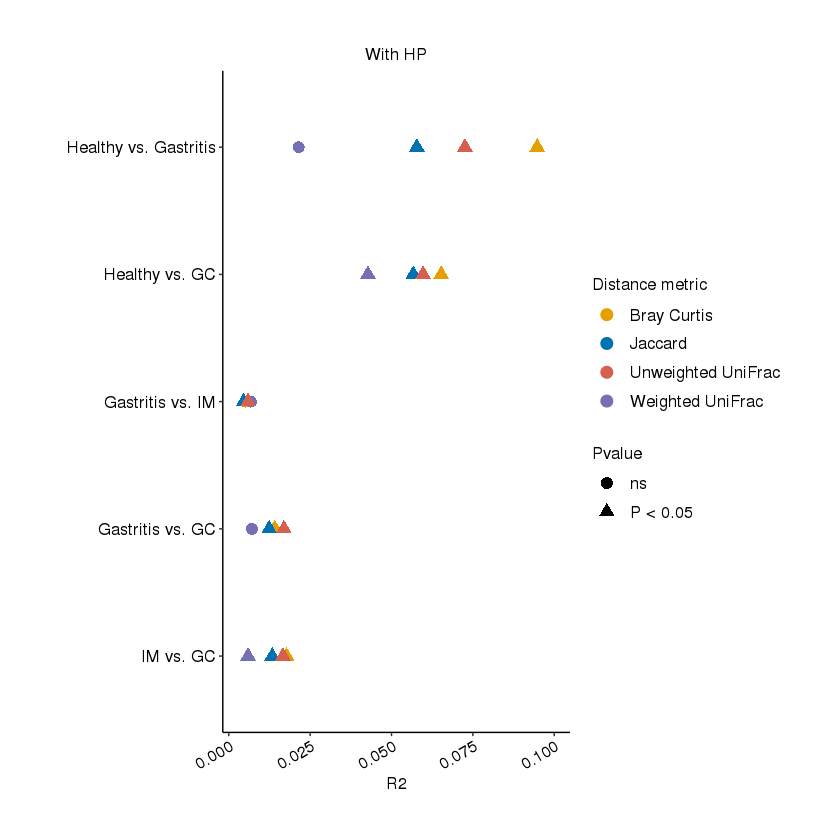

In [51]:
ggplot(data =combined_res , aes(x = R2, y =Compare,color=metric))+ geom_point(aes(shape =Pvalue),size=3)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ 
theme(axis.text.x = element_text(angle = 30, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
        legend.title = element_text(size = 10),
      legend.text = element_text(size = 10),
     plot.margin=unit(rep(2,4),'lines')
     )+ylab('')+scale_color_manual(values=col)+labs(color='Distance metric') + xlim(0.003,0.1)+
labs(title='With HP')+theme(plot.title = element_text(hjust = 0.5))#
ggsave("figures/dignosis_combined_adonis.pdf", device="pdf", height=5, width=5.5, useDingbats=F)

# metadata plot

In [75]:
library(RColorBrewer)
library(viridis)
library(ggsci)
library(wesanderson)
library(ggplot2)
library(gridExtra)

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:viridisLite’:

    viridis.map



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [79]:
ids <- which(mdplot$Sample_location=='')
mdplot$Sample_location[ids] <- mdplot$Tissue[ids]
#ids

In [80]:
mdplot$Diagnosis[which(mdplot$Diagnosis=='healthy')] <- 'Healthy'
mdplot$Diagnosis[which(mdplot$Diagnosis=='gastritis')] <- 'Gastritis'
mdplot$Diagnosis[which(mdplot$Diagnosis=='gastric cancer')] <- 'GC'
mdplot$Diagnosis[which(mdplot$Diagnosis=='intestinal metaplasia')] <- 'IM'
mdplot$Diagnosis <- factor(mdplot$Diagnosis,levels=c('Healthy','Gastritis','IM','GC'))

In [81]:
p310 <- mdplot %>% subset(BioProject=='PRJNA310127')
table(p310$Tissue)


non_tumor_tissue  tumorous tissue 
             157              134 

In [82]:
dim(p310)

[1] 291  50

In [83]:
table(p310$Sample_location)


non_tumor_tissue  tumorous tissue 
             157              134 

In [84]:
H="#E69F00"
L="#0072B2"   

In [89]:
mdplot$Sample_location[which(mdplot$Sample_location=='gastric fluid')] <- 'Gastric fluid'
mdplot$Sample_location[which(mdplot$Sample_location=='')] <- 'Unkown'
mdplot$Sample_location[which(mdplot$Sample_location=='para-cancer tissue')] <- 'Non-tumor tissue'
mdplot$Sample_location[which(mdplot$Sample_location=='non_tumor_tissue')] <- 'Non-tumor tissue'
mdplot$Sample_location[which(mdplot$Sample_location=='tumorous tissue')] <- 'Tumorous tissue'

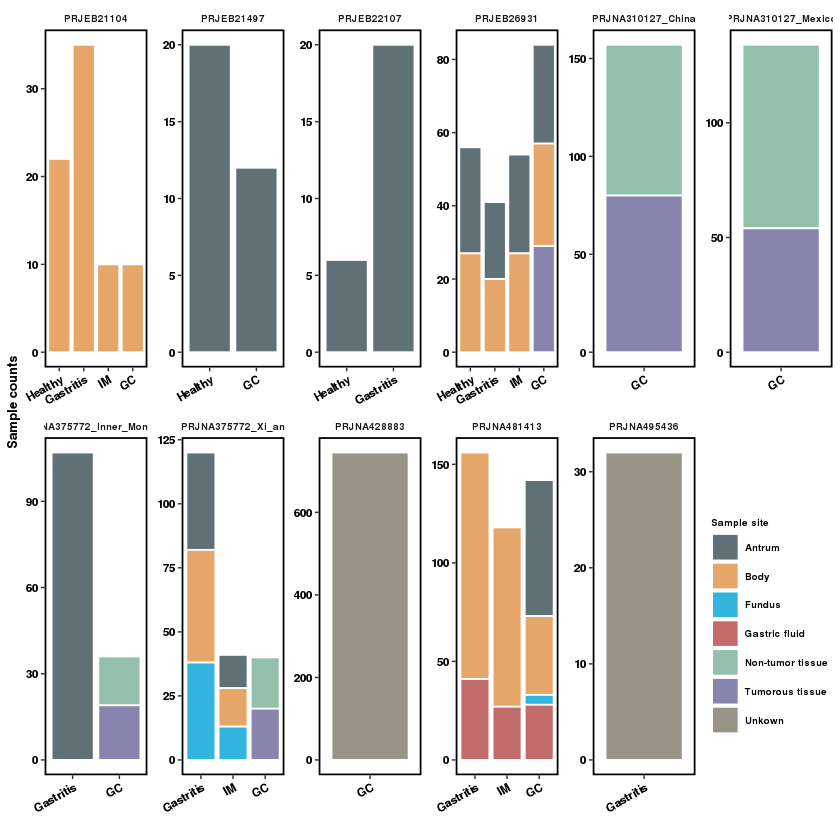

In [90]:

ggplot() + geom_bar(data = mdplot, aes(x =Diagnosis , group = Sample_location, fill = Sample_location), 
 stat = "count", lwd = .5, colour = "white",alpha = 0.8) + 
 facet_wrap(~Study,scales="free",ncol=6)+
 theme_MicrobeR()+
theme(axis.text.x = element_text(angle = 30, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 7,,face = "bold",colour = 'black'), 
        axis.title = element_text(size = 8,face = "bold"), #xlab,ylab
        plot.title = element_text(size = 7,face = "bold",hjust = 0.5),
        legend.title = element_text(size = 6,face = "bold"),
      legend.text = element_text(size = 6,face = "bold"),
     strip.text = element_text(size = 6,face = "bold"))+theme(legend.position = c(.92,0.2))+
labs(x='',y='Sample counts',fill='Sample site')+

ggsave("figures/metadata-Diagnosis-Sample_location.pdf", device="pdf", height=4, width=9.5, useDingbats=F)